In [1]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

# Neural Network Visualization Code

In [19]:
import networkx as nx
#nw=[[[2,4,1],[3,3,0.9]],[[5,1],[4,2]]]
#inputs=["in1", "in2", "in3"]
#outputs=["out1","out2"]
def visualizeNN(nw, inputs, outputs, unitThreshold=None):
    #arbitrary
    maxEdge=0
    minEdge=10

    edgeColors=[]
    layerCtr=0
    for layer in nw:
        
        for unit in layer:
            for edge in unit:
                if(edge>0):
                    edgeColors.append('#%02x%02x%02x' % (int(255-(255*layerCtr/(len(nw)+1))), 0, 0))
                else:
                    edgeColors.append('#%02x%02x%02x' % (0, 0, int(255-(255*layerCtr/(len(nw)+1)))))
                if(abs(edge)>maxEdge):
                    maxEdge=edge
                elif(abs(edge)<minEdge):
                    minEdge=edge
        layerCtr+=1

    normFactor=5/(maxEdge-minEdge)

    #as many as we have units, we have rightNodes, and as many as we have edges, we have leftNodes
    #create node arrays

    G = nx.DiGraph()

    layer_ctr=0
    clrCtr=0
    for layer in nw:
        unit_ctr=0
        for unit in layer:
            edge_ctr=0
            for edge in unit:
                if(layer_ctr!=0):
                    fromN="n"+str(layer_ctr)+"."+str(unit_ctr)
                else:
                    fromN=inputs[unit_ctr]

                if(layer_ctr<len(nw)-1):
                    toN="n"+str(layer_ctr+1)+"."+str(edge_ctr)
                else:
                    toN=outputs[edge_ctr]
                # normalize weight
                if(unitThreshold==None):
                    G.add_edge(fromN, toN, weight=abs(nw[layer_ctr][unit_ctr][edge_ctr]*normFactor), color=edgeColors[clrCtr])
                elif(abs(nw[layer_ctr][unit_ctr][edge_ctr]*normFactor)>=unitThreshold*10):
                    G.add_edge(fromN, toN, weight=abs(nw[layer_ctr][unit_ctr][edge_ctr]*normFactor), color=edgeColors[clrCtr])
                #print(edgeColors[clrCtr])
                edge_ctr+=1
                clrCtr+=1
            unit_ctr+=1
        layer_ctr+=1
    pos=[]
    i=0
    j=0
    for n in G.nodes:
        if(n.startswith('n')):
            coords=n[1:].split('.')
            pos.append((int(coords[0]),int(coords[1])))
        elif n in inputs:
            pos.append((0,i))
            i+=1
        elif n in outputs:
            pos.append((2,j))
            j+=1
    #print(pos)
    #layers = {"a": ["in1", "in2", "in3"], "b": ["N1.0","N1.1"], "c": ["out1", "out2"]}
    #pos = nx.multipartite_layout(G)
    edges = G.edges()
    #colors = [G[u][v]['color'] for u,v in edges]
    pos=nx.shell_layout(G)
    weights = [G[u][v]['weight'] for u,v in edges]
    colors = [G[u][v]['color'] for u,v in edges]

    nx.draw(G, width=weights, pos=pos, with_labels=True,arrows=True,arrowstyle='-|>', edge_color=colors)

19
Index(['PCL Mw', 'Acetone%', 'Acetonitrile%', '[PCL ] (mg/mL)', 'CTAB', 'SDS',
       'P188', 'Chitosan', 'Tween', 'Alginate', 'P407', '[Stabilizer] (%w/v)',
       'S/A Ratio', 'Solvent volume (mL)', 'Linear flow rate (mL/s)',
       'Mixing time (s)', 'IID (mm)'],
      dtype='object', name=0)
#0000ff
#ff0000
#ff0000
#ff0000
#0000ff
#0000ff
#0000ff
#ff0000
#ff0000
#0000ff
#ff0000
#ff0000
#ff0000
#0000ff
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#0000ff
#0000ff
#ff0000
#ff0000
#0000ff
#ff0000
#0000ff
#0000ff
#ff0000
#ff0000
#0000ff
#0000ff
#ff0000
#0000ff
#ff0000
#0000ff
#ff0000
#ff0000
#ff0000
#0000ff
#0000ff
#0000ff
#0000ff
#0000ff
#ff0000
#ff0000
#ff0000
#0000ff
#ff0000
#ff0000
#ff0000
#ff0000
#0000ff
#ff0000
#0000ff
#0000ff
#ff0000
#0000ff
#ff0000
#ff0000
#0000ff
#ff0000
#ff0000
#0000ff
#0000ff
#ff0000
#0000ff
#ff0000
#0000ff
#ff0000
#0000ff
#0000ff
#0000ff
#0000ff
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#0000ff
#ff0000
#ff0000
#ff0000
#ff0000
#ff0000
#000

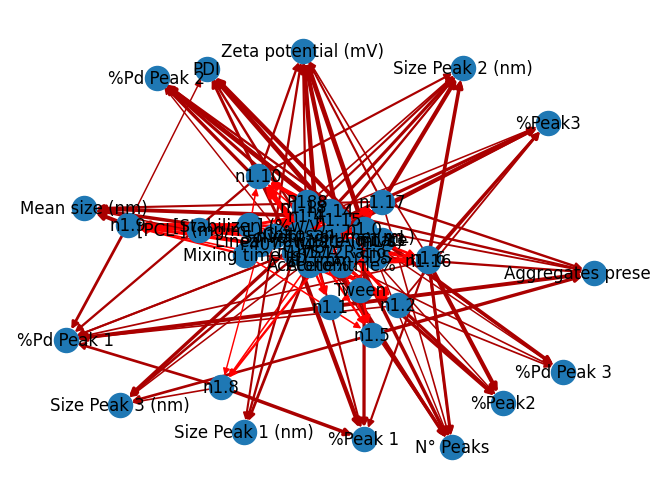

In [117]:
nw=[[[-1.52464385e-08,  1.87741778e-08,  8.83066719e-09,
         3.43572805e-08, -9.03953018e-08, -3.69494879e-08,
        -2.91805470e-08,  2.23741018e-08,  1.12920264e-10,
        -1.13570371e-08,  2.04320149e-08,  4.68083438e-08,
         1.44234626e-08, -3.65711804e-09,  1.78729195e-08,
         5.33646676e-08,  4.31786791e-08,  7.30312813e-08,
         8.77227971e-08],
       [-1.55062562e-01, -2.95169055e-01,  2.30132614e-01,
         3.57984371e-01, -1.69558009e-01,  2.85064506e-02,
        -4.92890713e-01, -1.95508682e-01,  1.50932720e-01,
         1.54631406e-01, -1.84593144e-01, -4.20150881e-01,
         1.34495806e-01, -1.42749361e-02,  3.18673268e-01,
        -3.47173023e-01,  2.89246823e-01,  1.86391859e-01,
         1.04335691e-01],
       [-2.94874519e-01, -1.29388868e-01, -6.15843477e-02,
        -3.48651702e-01, -4.73571567e-02,  1.40176768e-01,
         2.96861615e-02,  1.86503029e-02, -7.61299520e-02,
         7.80440978e-02,  8.18489006e-02,  1.09128984e-01,
         5.08707645e-01, -3.87595860e-02,  2.23402587e-01,
        -1.95520149e-01, -3.27669670e-02,  2.43825947e-02,
        -5.07311066e-02],
       [ 1.08046742e-01,  1.29231758e-01, -1.89328390e-01,
         1.81220168e-01,  5.18018777e-02, -2.28613224e-01,
        -2.10563258e-01,  8.87723785e-02, -3.51048467e-01,
         1.83426256e-01, -1.37130163e-01,  1.15425064e-01,
        -1.19119628e-01, -3.14809029e-01, -1.38785529e-01,
        -5.45278786e-01,  3.11077788e-02,  4.69253746e-02,
         6.74584345e-02],
       [ 4.79805072e-02,  2.21413375e-01,  9.39794120e-02,
         4.21977965e-01,  2.62480454e-01, -3.50889125e-01,
         4.40382687e-02,  7.03562202e-02,  9.47736601e-02,
         1.02639820e-01,  6.38526212e-02, -7.98108098e-02,
        -1.20928836e-01,  3.59647227e-02, -2.52913138e-02,
        -1.58178827e-02,  4.26725808e-03,  2.49898589e-02,
         2.98166861e-01],
       [-4.18863085e-01,  1.89269897e-02,  3.22818532e-02,
        -4.36755990e-02,  4.06119880e-02, -2.39937143e-01,
         4.85303587e-02, -3.70892515e-02, -4.33833027e-01,
         5.75645775e-02, -1.09802440e-01, -3.95453507e-01,
         2.94127325e-01, -1.25237766e-03, -9.20469097e-02,
        -4.62776541e-01,  3.19712074e-01, -1.01131787e-01,
         2.59147831e-02],
       [ 8.54293101e-02, -1.33239413e-01, -6.29339810e-02,
        -3.82334183e-02,  3.39832633e-01, -8.09096701e-02,
        -2.79631704e-01, -1.46739111e-01, -2.03941322e-03,
         7.35687977e-02,  3.81301615e-01,  3.95863157e-02,
        -1.63709507e-01,  1.33881024e-01,  9.77112932e-02,
         1.60153304e-01,  1.39876525e-02, -2.50100186e-01,
         2.52194213e-01],
       [ 6.93448973e-01, -6.64319756e-01, -1.51308176e-03,
         5.10672956e-03,  5.16884934e-01, -2.52441638e-01,
        -7.88260106e-01, -1.31048399e-01, -4.89541107e-01,
         3.18317926e-01, -2.71706074e-02,  6.57099245e-01,
        -1.82489311e-01, -1.11190431e-01,  1.34876456e-01,
        -6.45852655e-02,  3.28028997e-01, -4.73443301e-01,
         2.95699386e-01],
       [ 1.48662192e-01,  1.95011310e-01,  6.02258194e-03,
        -4.63856204e-02,  3.29625719e-02,  2.10191709e-01,
        -1.52472982e-01, -1.36816369e-01, -1.91487417e-02,
        -7.44925473e-02,  1.04154915e-01, -2.50484294e-02,
        -3.85403392e-01,  2.26885689e-02, -2.95712088e-03,
         7.98194803e-02, -6.91010595e-02,  1.70703786e-02,
        -1.47643962e-01],
       [-1.45326561e-01, -1.45188822e-01, -8.21854495e-02,
         4.92183243e-02,  1.61792046e-01, -1.99392523e-01,
        -1.91943000e-01,  1.08257595e-01, -2.17621068e-01,
        -2.48261334e-02,  1.04458797e-01, -3.49029785e-01,
         1.39324945e-02, -8.40285927e-02, -1.88473249e-01,
        -2.86999759e-02,  2.50168528e-01, -7.52503883e-02,
         1.19337321e-01],
       [ 1.44933877e-01,  4.56444056e-02, -1.64646998e-01,
        -1.21376625e-01,  2.52849408e-01, -5.63071733e-01,
        -1.63427203e-01, -2.21323609e-01,  1.34996796e-01,
         3.24531693e-01, -3.83782423e-02,  3.39666438e-01,
         1.68037734e-02, -2.99382015e-01,  3.37525445e-01,
        -1.53523927e-01,  1.46709910e-02, -1.29782269e-01,
         4.96120168e-01],
       [ 2.79077890e-01, -2.72046714e-01, -4.19699370e-02,
        -3.44825652e-01, -1.05969596e-01,  9.74757277e-02,
        -9.85670259e-02, -3.99363877e-01, -7.22019018e-02,
         4.39228692e-01, -9.87247842e-02,  1.98861395e-01,
        -1.79592418e-01, -3.02957240e-01,  2.74650249e-01,
         7.28508243e-02,  5.91731655e-02, -2.16308141e-01,
         1.31248807e-01],
       [-1.17880923e-01,  1.14622752e-01,  3.03435462e-01,
        -1.08456028e-01,  3.89099505e-01, -3.68662106e-01,
        -4.74428143e-02, -1.00803858e-01,  7.17359073e-02,
        -1.98466359e-01, -1.93955599e-01, -1.52177957e-01,
        -1.76624213e-01,  6.87112793e-02,  2.38601920e-01,
        -3.84536829e-01,  1.25559044e-01, -6.93613954e-02,
        -4.35984368e-02],
       [ 1.46622247e-01, -1.74674158e-01, -1.79259340e-01,
        -8.72900647e-02,  1.41959912e-01,  1.71947303e-01,
         5.12330936e-03,  3.43154329e-01, -2.79436787e-01,
        -1.44092788e-01,  1.65178658e-01,  3.19243589e-01,
        -1.34132280e-02, -7.39437688e-02, -3.38543154e-01,
        -1.51880281e-01, -9.92696727e-02,  2.65847603e-01,
         3.63238958e-01],
       [ 1.90358757e-01,  2.34434764e-01,  2.60456252e-01,
         1.97906763e-01,  1.68010523e-01, -7.73817894e-02,
        -4.26929925e-01,  7.41419882e-02, -4.18776901e-01,
         2.10902680e-01,  2.55161854e-01,  6.67866455e-02,
         1.56073863e-01, -1.22749405e-01,  1.04434684e-01,
        -5.85166960e-01,  1.56019839e-01,  3.51938364e-01,
        -1.90705460e-01],
       [ 2.52538698e-02,  4.54377925e-03, -6.48796916e-02,
        -2.78525728e-02,  2.13200720e-02,  1.49216973e-01,
         2.84582491e-02, -4.14118267e-02, -7.98319784e-02,
         2.20830757e-01,  1.48026001e-01, -4.93333286e-02,
         3.73582985e-02, -1.76962511e-01,  3.60098996e-02,
        -8.86567022e-03,  5.99870362e-02, -2.31665523e-01,
         4.82581343e-02],
       [ 1.34385604e-01,  2.84610569e-02,  3.92691336e-01,
        -1.43916085e-01,  1.36914165e-02,  2.19437126e-01,
        -4.34114297e-01,  3.40360065e-01,  2.25564030e-01,
        -8.09780853e-02,  5.34521641e-01,  1.03507965e-02,
        -2.04041454e-01, -8.35669770e-02, -2.22882941e-01,
        -6.32012320e-01,  3.48976512e-01,  2.36491913e-01,
         5.16033964e-01]], [[-3.46448615e-01,  3.96871679e-01,  4.39438029e-01,
        -1.62747278e-01, -2.24518370e-01,  1.76700275e-01,
        -2.36704919e-01, -3.93286263e-02, -5.55990616e-02,
         3.08040207e-01, -2.23295036e-01, -5.87888858e-02,
         1.38391333e-01,  1.74570846e-01],
       [-4.70415806e-01,  3.34323418e-04, -8.83466653e-03,
         3.68150029e-01, -5.97805897e-02, -1.50464979e-01,
        -2.30441734e-01,  1.14768255e-01, -3.47808351e-01,
        -2.87422535e-01, -3.11883517e-01, -2.71173743e-01,
        -5.45808056e-02,  3.69866069e-01],
       [-1.14280320e-01, -3.10419909e-01,  1.25399549e-02,
         1.57550415e-01,  1.27821989e-01,  1.62483008e-01,
         2.07889587e-02,  5.71004123e-02,  5.41918841e-02,
        -2.62954396e-01,  3.08298036e-01,  1.72651266e-01,
        -1.03848255e-02, -2.49545883e-01],
       [ 1.10410861e-01,  8.95576526e-03,  2.22233411e-01,
        -4.80113843e-02, -2.97468155e-01, -3.04502263e-01,
         1.97732808e-01, -1.59340043e-01,  1.47397908e-02,
        -8.39962124e-02,  5.31929987e-03,  1.25981436e-02,
         1.08816799e-01,  1.09466879e-01],
       [ 3.63326574e-01,  9.45465014e-02,  2.12874784e-01,
        -1.71934478e-01, -3.57897973e-01,  9.84848703e-02,
         1.36251378e-02,  2.07839046e-01, -2.66141147e-01,
        -3.15335807e-01, -1.58654077e-01,  2.93195892e-02,
         2.03040167e-01, -4.08138365e-01],
       [ 1.20681961e-01,  8.69992647e-02, -1.28970072e-01,
        -1.98301338e-01, -2.67765255e-01, -5.71985097e-02,
         3.45521827e-02, -2.61634479e-01,  2.50074230e-01,
         1.01777588e-02,  8.58259394e-02,  3.89595627e-02,
        -2.19970963e-01,  3.17368426e-01],
       [-3.33775618e-01, -4.38203139e-01,  1.57077563e-01,
        -4.17402827e-01, -9.38428542e-02, -2.71958474e-01,
        -3.71793858e-02,  1.31665343e-01, -2.71625059e-01,
         2.06194708e-01, -1.36662933e-01,  2.44190927e-01,
         2.93340247e-01, -1.28219975e-01],
       [ 1.37600770e-01,  2.76611388e-01, -2.90620422e-01,
         1.87859526e-01,  1.39009094e-01, -2.91966564e-01,
         2.23006610e-01, -5.00360194e-01, -2.30067009e-01,
         3.99357144e-01, -2.56310550e-01,  3.16633340e-01,
        -2.72273295e-01,  6.57911268e-02],
       [-6.43396486e-02, -9.04344362e-02,  5.94647616e-02,
         2.51304293e-01, -1.28689837e-01,  6.25328113e-02,
        -6.39997170e-02, -1.18477015e-01,  1.53429159e-01,
         3.31595998e-01, -1.45840469e-01, -3.01325074e-03,
         7.57273769e-02, -3.23254326e-01],
       [ 3.72001205e-01,  1.39204806e-01, -2.50498526e-01,
         2.63027378e-01, -1.19505884e-02,  1.16315154e-01,
        -3.39021753e-01, -2.07265312e-01,  1.58329468e-02,
        -4.31358020e-02,  2.76076708e-02, -1.43718351e-01,
        -1.70044119e-01, -2.86985913e-01],
       [-1.25717364e-01, -1.72168205e-01,  2.24334476e-01,
         2.21291239e-01, -4.09784216e-01, -3.24086919e-01,
        -1.84579654e-01,  2.07844207e-01, -7.86666306e-02,
        -4.80196035e-02,  4.54223056e-02, -1.42300178e-01,
        -3.52213360e-02, -3.17049310e-02],
       [ 3.28942606e-01, -2.71503719e-01,  4.14482420e-01,
         1.97075406e-01,  3.10078358e-01, -2.66339238e-01,
         2.63547625e-01,  1.65946694e-01, -7.06852850e-02,
        -1.29405736e-01,  3.17805720e-01,  2.61961210e-01,
         3.23571339e-01,  8.76122755e-02],
       [-1.81305920e-01,  2.34942134e-01,  1.44994749e-01,
         5.31389836e-02, -2.65711378e-01,  1.56317362e-01,
        -2.67840672e-01,  8.11575130e-02,  1.46129104e-01,
        -8.92920262e-02, -2.12467697e-01, -1.56745837e-01,
         1.31756085e-01, -4.60025465e-01],
       [ 9.20034639e-02, -1.99496037e-01, -1.72386467e-01,
        -1.94130163e-01,  2.24296516e-01,  3.45132718e-01,
        -2.82929003e-01, -4.81212208e-02, -1.61384767e-01,
        -8.72890128e-02,  1.13767472e-01, -2.52214269e-01,
        -2.48908599e-01, -3.46987388e-01],
       [-1.95574711e-01,  4.45161772e-01, -5.32018036e-02,
        -2.51648591e-01,  1.63228861e-01, -1.75041372e-01,
        -8.15881715e-02,  2.97331282e-01,  3.18402513e-01,
        -2.42893095e-01,  1.43827257e-01,  1.49559109e-01,
        -7.05389299e-02,  2.27008137e-01],
       [-2.20960697e-02,  5.16622708e-02,  4.00348071e-01,
        -1.49819668e-01,  4.40916988e-01,  1.41293411e-01,
         3.84107818e-02,  1.51108864e-01,  2.38937377e-01,
        -2.67018332e-01,  4.65855354e-02,  2.97952495e-01,
         3.26294735e-01, -1.61525718e-01],
       [-1.37822677e-01, -5.49081270e-02,  3.88308431e-02,
         1.63475320e-01, -1.45700740e-01, -3.79817939e-01,
        -1.64959474e-01,  3.41072141e-01, -2.70167302e-01,
        -2.71385388e-01,  3.96844797e-01,  2.44695286e-01,
         1.58284434e-01,  2.17558651e-01],
       [ 1.98346336e-01,  6.16692367e-02,  1.97756868e-01,
        -3.75619063e-01, -2.30064296e-01, -4.58641130e-01,
        -3.04881380e-01,  3.98899942e-01, -5.84402535e-02,
        -2.39929045e-02, -3.77322953e-01,  1.04980430e-01,
         1.54020994e-01,  2.29461083e-01],
       [-1.10333877e-01, -9.90993878e-02,  8.66993669e-02,
        -2.13105148e-01,  2.94954394e-01, -9.22501027e-03,
         8.60577541e-02,  1.59716365e-01,  8.12601790e-02,
         1.95872262e-01,  7.95483221e-02, -2.02564689e-02,
        -4.42423172e-01,  1.17704834e-01]]]
#print(len(nw[1]))
#print(xArr.columns)
visualizeNN(nw,xArr.columns,yArr.columns,0.1)

# Data Processing

In [48]:
import pandas as pd
import numpy as np

df=pd.read_excel('/kaggle/input/np-data/NP_Dataset.xlsx')

# specify range of table and define columns
inputDf=df.iloc[1:300,1:27]
titles=df.iloc[0,1:27]
inputDf.columns=titles

inputDf.index=range(0,len(inputDf.index)) # update row numbers

inputDf.drop(['IID'],axis='columns', inplace=True) # IID (mm) column is representative of IID column
inputDf['Aggregates presence ']=(inputDf["Aggregates presence "]=="YES").astype(int) # to remove strings in data
inputDf['PCL Mw']=(inputDf["PCL Mw"]=="HIGH").astype(int) # to remove strings in data


stabilizers = list(set(inputDf['Stabilizer'])) # get list of stabilizers used
'''
# make a separate binary-type column for each unique entry in Stabilizer column
for s in stabilizers:
    inputDf.insert (5, s, (inputDf["Stabilizer"]==s).astype(int))
''' 
# choose rows for one stabilizer
chosenS=stabilizers[0]
print(chosenS)
inputDf=inputDf.loc[inputDf['Stabilizer']==chosenS]

# remove Stabilizer column (all its data are now in the new columns)
inputDf.drop(['Stabilizer'],axis='columns', inplace=True)


#display(inputDf)
#inputDf.to_excel("inputDf.xlsx")

yArr=inputDf[['Mean size (nm)', 'PDI', 'Zeta potential (mV)', '%Pd Peak 1', '%Pd Peak 2', '%Pd Peak 3', 'Size Peak 1 (nm)', 'Size Peak 2 (nm)', 'Size Peak 3 (nm)', '%Peak 1', '%Peak2', '%Peak3', 'N° Peaks', 'Aggregates presence ']]
xArr=inputDf.iloc[:,0:10]
print("yArr")
display(yArr)
print("xArr")
display(xArr)

Chitosan
yArr


,Mean size (nm),PDI,Zeta potential (mV),%Pd Peak 1,%Pd Peak 2,%Pd Peak 3,Size Peak 1 (nm),Size Peak 2 (nm),Size Peak 3 (nm),%Peak 1,%Peak2,%Peak3,N° Peaks,Aggregates presence
104,499.1,0.328,86.9,52,0,0,755.7,0,0,100,0,0,1,0
105,949.5,0.485,84.2,59.9,0,0,1692,0,0,100,0,0,1,0
106,809.2,0.539,91.7,63,0,0,1559,0,0,100,0,0,1,0
107,912.3,0.604,81.7,63.5,0,0,1809,0,0,100,0,0,1,0
108,820.2,0.554,84.4,55,26.4,0,370.4,1760,0,17.66,82.34,0,2,0
109,881.7,0.396,94.9,37.3,23.3,0,217.1,1513,0,9.391,90.61,0,2,0
110,1687,0.519,84.7,42.2,26.9,0,570.6,2936,0,11.01,88.99,0,2,0
111,486.1,0.421,85.2,38.3,20.9,0,70.63,686.9,0,5.511,94.49,0,2,0
112,496.3,0.472,86.3,42.2,24.3,0,119,874.7,0,10.32,89.68,0,2,0
113,944.9,0.524,82.8,47.6,22.5,0,193.3,1800,0,10.5,89.5,0,2,0


xArr


,PCL Mw,Acetone%,Acetonitrile%,[PCL ] (mg/mL),[Stabilizer] (%w/v),S/A Ratio,Solvent volume (mL),Linear flow rate (mL/s),Mixing time (s),IID (mm)
104,0,100,0,1,0.05,0.125,1,3.49854,0.285834,0.838
105,0,100,0,1,0.1,0.125,1,3.49854,0.285834,0.838
106,0,100,0,1,0.2,0.125,1,3.49854,0.285834,0.838
107,0,100,0,1,0.1,0.125,1,3.49854,0.285834,0.838
108,0,100,0,1,0.2,0.125,1,3.49854,0.285834,0.838
109,0,100,0,1,0.2,0.125,1,3.49854,0.285834,0.838
110,0,100,0,1,0.2,0.5,4,3.49854,1.14333,0.838
111,0,100,0,1,0.05,0.125,1,3.49854,0.285834,0.838
112,0,100,0,1,0.05,0.125,1,3.49854,0.285834,0.838
113,0,100,0,1,0.1,0.125,1,3.49854,0.285834,0.838


# Defining Models

In [32]:
# NESTED_CV_
# import the necessary libraries to execute this code
from ctypes import sizeof
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from ipywidgets import interact
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, normalize
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, ShuffleSplit
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

# import model frameworks
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from ngboost import NGBRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV

class NESTED_CV:

    """
    NESTED_CV Class:
    - based on a dataset for long acting injectible (LAI) drug delivey systems
    - contains 12 different model architectures and non-exaustive hyperparamater spaces for those models
    - actiavted by abbriviations for these model - incorrect keywords triggers a message with available key words
    - once model type is selected, NEST_CV will be conducted, data is spli as follows:
          - outer_loop (test) done by GroupShuffleSplit where 20% of the drug-polymer groups in the dataset are held back at random
          - inner_loop (HP screening) done by GroupKFold based 10 splits in the dataset - based on drug-polymer groups
    - default is 10-folds for the NESTED_CV, but this can be entered manually
    - prints progress and reults at the end of each loop
    - configures a pandas dataframe with the reults of the NESTED_CV
    - fits and trains the best model based on the reults of the NESTED_CV
    """

    def __init__(self, datafile = "/kaggle/input/np-data/NP_Dataset.xlsx", model_type = None):
        self.df = pd.read_excel(datafile)
        self.df = self.df.transpose() # to make each row correspond to each patient

        if model_type == 'MLR':
          self.user_defined_model = LinearRegression()
          self.p_grid = {'fit_intercept':[True, False],
                         'positive':[True, False]}
            
        if model_type == 'LR':
          self.user_defined_model = LogisticRegression()
          self.p_grid = {'fit_intercept':[True, False]}

        elif model_type == 'lasso':
          self.user_defined_model = linear_model.Lasso()
          self.p_grid = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1.0],
                        'positive':[True, False]}

        elif model_type == 'kNN':
          self.user_defined_model = KNeighborsRegressor()
          self.p_grid ={'n_neighbors':[2, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 50],
                        'weights': ["uniform", 'distance'],
                        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                        'leaf_size': [10, 30, 50, 75, 100],
                        'p':[1, 2],
                        'metric': ['minkowski']}

        elif model_type == 'PLS':
          self.user_defined_model = PLSRegression()
          self.p_grid ={'n_components':[2, 4, 6],
                        'max_iter': [250, 500, 750, 1000]}

        elif model_type == 'SVR':
          self.user_defined_model = SVR()
          self.p_grid ={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                        'degree':[2, 3, 4, 5, 6],
                        'gamma':['scale', 'auto'],
                        'C':[0.1, 0.5, 1, 2],
                        'epsilon':[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2],
                        'shrinking': [True, False]}

        elif model_type == 'DT':
          self.user_defined_model = DecisionTreeRegressor(random_state=4)
          self.p_grid ={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                        'splitter':['best', 'random'],
                        'max_depth':[None],
                        'min_samples_split':[2,4,6],
                        'min_samples_leaf':[1,2,4],
                        'max_features': [None, 'auto', 'sqrt','log2'],
                        'ccp_alpha': [0, 0.05, 0.1, 0.15]}

        elif model_type == 'RF':
          self.user_defined_model = RandomForestRegressor(random_state=4)
          self.p_grid ={'n_estimators':[100,300,400],
                        'criterion':['squared_error', 'absolute_error'],
                        'max_depth':[None],
                        'min_samples_split':[2,4,6,8],
                        'min_samples_leaf':[1,2,4],
                        'min_weight_fraction_leaf':[0.0],
                        'max_features': ['1', 'sqrt'],
                        'max_leaf_nodes':[None],
                        'min_impurity_decrease': [0.0],
                        'bootstrap':[True],
                        'oob_score':[True],
                        'ccp_alpha': [0, 0.005, 0.01]}

        elif model_type == 'LGBM':
          self.user_defined_model = LGBMRegressor(random_state=4)
          self.p_grid ={"n_estimators":[100,150,200,250,300,400,500,600],
                        'boosting_type': ['gbdt', 'dart', 'goss'],
                        'num_leaves':[16,32,64,128,256],
                        'learning_rate':[0.1,0.01,0.001,0.0001],
                        'min_child_weight': [0.001,0.01,0.1,1.0,10.0],
                        'subsample': [0.4,0.6,0.8,1.0],
                        'min_child_samples':[2,10,20,40,100],
                        'reg_alpha': [0, 0.005, 0.01, 0.015],
                        'reg_lambda': [0, 0.005, 0.01, 0.015]}

        elif model_type == 'XGB':
          self.user_defined_model = XGBRegressor(objective ='reg:squarederror')
          self.p_grid ={'booster': ['gbtree', 'gblinear', 'dart'],
                        "n_estimators":[100, 150, 300, 400],
                        'max_depth':[3, 4, 5, 6, 7, 8, 9, 10],
                        'gamma':[0, 2, 4, 6, 8, 10],
                        'learning_rate':[0.3, 0.2, 0.1, 0.05, 0.01],
                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        'min_child_weight': [1.0, 2.0, 4.0, 5.0],
                        'max_delta_step':[1, 2, 4, 6, 8, 10],
                        'reg_alpha':[0.001, 0.01, 0.1],
                        'reg_lambda': [0.001, 0.01, 0.1]}

        elif model_type == 'NGB':
          b1 = DecisionTreeRegressor(criterion='squared_error', max_depth=2)
          b2 = DecisionTreeRegressor(criterion='squared_error', max_depth=4)
          b3 = DecisionTreeRegressor(criterion='squared_error', max_depth=8)
          b4 = DecisionTreeRegressor(criterion='squared_error', max_depth=12)
          b5 = DecisionTreeRegressor(criterion='squared_error', max_depth=16)
          b6 = DecisionTreeRegressor(criterion='squared_error', max_depth=32)
          self.user_defined_model = NGBRegressor()
          self.p_grid ={'n_estimators':[100,200,300,400,500,600,800],
                        'learning_rate': [0.1, 0.01, 0.001],
                        'minibatch_frac': [1.0, 0.8, 0.5],
                        'col_sample': [1, 0.8, 0.5],
                        'Base': [b1, b2, b3, b4, b5, b6]}
            
        elif model_type == 'NN':
          self.user_defined_model = MLPRegressor()
          self.p_grid ={"hidden_layer_sizes" : [()],
                         "learning_rate_init": [0.0001,0.001,0.01],
                         "alpha":[1e-2,1e-3,1e-4],
                         "batch_size":[16 ,32, 64, 128, 256],
                         "activation": ['tanh', 'logistic', 'relu']}

        else:
          print("#######################\nSELECTION UNAVAILABLE!\n#######################\n\nPlease chose one of the following options:\n\n 'MLR'for multiple linear regression\n\n 'lasso' for multiple linear regression with east absolute shrinkage and selection operator (lasso)\n\n 'kNN'for k-Nearest Neighbors\n\n 'PLS' for partial least squares\n\n 'SVR' for support vertor regressor\n\n 'DT' for decision tree\n\n 'RF' for random forest\n\n 'LGBM' for LightGBM\n\n 'XGB' for XGBoost\n\n 'NGB' for NGBoost")
    
    def input_target(self):
        '''
        #self.Y=yArr
        stdScale=StandardScaler().fit(yArr)
        self.Y=stdScale.transform(yArr)

        #xArr.columns = xArr.columns.astype(str)
        stdScale=StandardScaler().fit(xArr)
        self.X=stdScale.transform(xArr)
        
        self.G=gArr
        '''
        #nrml=Normalizer().fit(yArr)
        #self.Y=nrml.transform(yArr)
        self.Y=normalize(yArr,axis=0)

        #nrml=Normalizer().fit(xArr)
        #self.X=nrml.transform(xArr)
        self.X=normalize(xArr,axis=0)
        
        self.G=gArr
        
        display(self.X)
        display(self.Y)

    def cross_validation(self, input_value):
        if input_value == None:
            NUM_TRIALS = 10
        else:
            NUM_TRIALS = input_value

        self.itr_number = [] # create new empty list for itr number
        self.outer_results = []
        self.inner_results = []
        self.model_params = []
        self.y_test_list = []
        self.pred_list = []

        for i in range(NUM_TRIALS): #configure the cross-validation procedure - outer loop (test set)

          cv_outer = ShuffleSplit(n_splits=1, test_size=0.4, random_state=i) #hold back 20% of the groups for test set

          # split data using GSS
          for train_index, test_index in cv_outer.split(self.X, self.Y):
              X_train, X_test = self.X[train_index], self.X[test_index]
              y_train, y_test = self.Y[train_index], self.Y[test_index]
              g_train, g_test = self.G[train_index], self.G[test_index]
            

              # store test set information
              y_test = np.array(y_test) #prevents index from being brought from dataframe
              self.y_test_list.append(y_test)

              # configure the cross-validation procedure - inner loop (validation set/HP optimization)
              cv_inner = KFold(n_splits=8) #should be 10 fold group split for inner loop

              # define search space
              search = RSCV(self.user_defined_model, self.p_grid, n_iter=100, verbose=0, scoring='neg_mean_absolute_error', cv=cv_inner,  n_jobs= 6, refit=True) # should be 100

              # execute search
              result = search.fit(X_train, y_train)

              # get the best performing model fit on the whole training set
              best_model = result.best_estimator_

              # get the score for the best performing model and store
              best_score = abs(result.best_score_)
              self.inner_results.append(best_score)

              # evaluate model on the hold out dataset
              yhat = best_model.predict(X_test)

              # store drug release predictions
              self.pred_list.append(yhat)

              # evaluate the model
              acc = mean_absolute_error(y_test, yhat)

              # store the result
              self.itr_number.append(i+1)
              self.outer_results.append(acc)
              self.model_params.append(result.best_params_)

              # report progress at end of each inner loop
              print('\n################################################################\n\nSTATUS REPORT:')
              print('Iteration '+str(i+1)+' of '+str(NUM_TRIALS)+' runs completed')
              print('Test_Score: %.3f, Best_Valid_Score: %.3f, \n\nBest_Model_Params: \n%s' % (acc, best_score, result.best_params_))
              print("\n################################################################\n ")

    def results(self):
        #create dataframe with results of nested CV
        list_of_tuples = list(zip(self.itr_number, self.inner_results, self.outer_results, self.model_params, self.y_test_list, self.pred_list))
        CV_dataset = pd.DataFrame(list_of_tuples, columns=['itr_num', 'Valid Score', 'Test Score', 'params', 'y_test_list', 'pred_list'])
        CV_dataset['Score_difference'] = abs(CV_dataset['Valid Score'] - CV_dataset['Test Score']) #Groupby dataframe model iterations that best fit the data (i.e., validitaion <= test)
        CV_dataset.sort_values(by=['Score_difference', 'Test Score'], ascending=True, inplace=True)
        CV_dataset = CV_dataset.reset_index(drop=True) # Reset index of dataframe
        # save the results as a class object
        self.CV_dataset = CV_dataset
        print(CV_dataset)

    def best_model(self):
        # assign the best model paramaters
        best_model_params = self.CV_dataset.iloc[0,3]
        # set params from the best model to a class object
        best_model = self.user_defined_model.set_params(**best_model_params)
        self.best_model = best_model.fit(self.X, self.Y)
        
        #highest3feat=sorted(zip(-(self.best_model.coef_[0]), featureTitles), reverse=True)[:3]
        #print(self.best_model.coef_[0])
        #print(highest3feat)
    
    def plot3D(self):
        #highest3feat=sorted(zip(abs(self.best_model.coef_[0]), featureTitles), reverse=True)[:3] # Logistic Regression
        print(self.best_model.feature_importances_)
        highest3feat=sorted(zip((self.best_model.feature_importances_), featureTitles), reverse=True)[:3] # Decision Trees
        print(highest3feat)
        fig=plt.figure()
        ax=fig.add_subplot(projection='3d')
        pdX=pd.DataFrame(data=self.X,columns=featureTitles)
        display(pdX)
        xs=pdX[highest3feat[0][1]]
        ys=pdX[highest3feat[1][1]]
        zs=pdX[highest3feat[2][1]]
        clrs=(self.Y>0)
                
        ax.scatter(xs,ys,zs,c=clrs, cmap = 'coolwarm')
        
        ax.set_xlabel(highest3feat[0][1])
        ax.set_ylabel(highest3feat[1][1])
        ax.set_zlabel(highest3feat[2][1])
        plt.show()
        
    def getWeightsMatrix(self):
        print(self.best_model.coefs_)
    
    def visualizeWeights(self):
        visualizeNN(self.best_model.coefs_, list(xArr.columns), list(yArr.columns))


In [33]:
def run_NESTED_CV(name, CV):

  """
  Function that:
  - runs the NESTED_CV for a desired model in the class and for a given number of folds
  - default is 10-folds i.e., CV = None
  - prints status and progress of NESTED_CV
  - formats the results as a datafarme, and saves them locally
  - assigns the best HPs to the model, trains, and saves its locally
  - then returns the results dataframe and the saved model
  """
  if __name__ == '__main__':
    model_instance = NESTED_CV(model_type = name)
    model_instance.input_target()
    model_instance.cross_validation(CV)
    model_instance.results()
    model_instance.best_model()
    #model_instance.getWeightsMatrix()
    #model_instance.visualizeWeights()
    #model_instance.plot3D()
    #model_instance.CV_dataset.to_pickle("NESTED_CV_RESULTS/"+str(name)+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    #with open('Trained_models/'+str(name)+'_model.pkl', 'wb') as file: # Save the Model to pickle file
    

    model_instance.CV_dataset.to_pickle("/kaggle/working/"+str(name)+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    with open("/kaggle/working/"+str(name)+'_model.pkl', 'wb') as file: # Save the Model to pickle file
          pickle.dump(model_instance.best_model, file)
    return model_instance.CV_dataset, model_instance.best_model

In [34]:
NESTED_CV()

#######################
SELECTION UNAVAILABLE!
#######################

Please chose one of the following options:

 'MLR'for multiple linear regression

 'lasso' for multiple linear regression with east absolute shrinkage and selection operator (lasso)

 'kNN'for k-Nearest Neighbors

 'PLS' for partial least squares

 'SVR' for support vertor regressor

 'DT' for decision tree

 'RF' for random forest

 'LGBM' for LightGBM

 'XGB' for XGBoost

 'NGB' for NGBoost


# Running Models

In [49]:
MLR_result, MLR_model = run_NESTED_CV("MLR", None)

#######################
SELECTION UNAVAILABLE!
#######################

Please chose one of the following options:

 'MLR'for multiple linear regression

 'lasso' for multiple linear regression with east absolute shrinkage and selection operator (lasso)

 'kNN'for k-Nearest Neighbors

 'PLS' for partial least squares

 'SVR' for support vertor regressor

 'DT' for decision tree

 'RF' for random forest

 'LGBM' for LightGBM

 'XGB' for XGBoost

 'NGB' for NGBoost


array([[0.        , 0.21821789, 0.        , 0.21821789, 0.07322913,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.14645826,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.29291652,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.14645826,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.29291652,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.29291652,
        0.12309149, 0.12309149, 0.21821789, 0.12309196, 0.21821789],
       [0.        , 0.21821789, 0.        , 0.21821789, 0.29291652,
        0.49236596, 0.49236596, 0.21821789, 0.49236526, 0.21821789],
       [0.        , 0.21821789, 0.       

array([[0.11869643, 0.14979065, 0.23127504, 0.23582849, 0.        ,
        0.        , 0.23398122, 0.        , 0.        , 0.44421566,
        0.        , 0.        , 0.10153462, 0.        ],
       [0.22581098, 0.22148922, 0.22408928, 0.27165628, 0.        ,
        0.        , 0.52388014, 0.        , 0.        , 0.44421566,
        0.        , 0.        , 0.10153462, 0.        ],
       [0.19244471, 0.24614988, 0.24404972, 0.28571528, 0.        ,
        0.        , 0.48270043, 0.        , 0.        , 0.44421566,
        0.        , 0.        , 0.10153462, 0.        ],
       [0.21696404, 0.275834  , 0.21743579, 0.28798287, 0.        ,
        0.        , 0.56010589, 0.        , 0.        , 0.44421566,
        0.        , 0.        , 0.10153462, 0.        ],
       [0.19506074, 0.25300006, 0.22462155, 0.24943398, 0.27658251,
        0.        , 0.11468393, 0.21743392, 0.        , 0.07844849,
        0.2335029 , 0.        , 0.20306923, 0.        ],
       [0.20968672, 0.18084481, 0.2


################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 0.094, Best_Valid_Score: 0.111, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 0.092, Best_Valid_Score: 0.070, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.091, Best_Valid_Score: 0.098, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.098, Best_Valid_Score: 0.068, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.093, Best_Valid_Score: 0.085, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 0.108, Best_Valid_Score: 0.052, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Scor

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.094, Best_Valid_Score: 0.094, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.105, Best_Valid_Score: 0.126, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 

################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.091, Best_Valid_Score: 0.115, 

Best_Model_Params: 
{'positive': True, 'fit_intercept': False}

################################################################
 
   itr_num  Valid Score  Test Score  \
0        8     0.094392    0.094289   
1        5     0.085473    0.092573   
2     

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 0.706, Best_Valid_Score: 0.467, 

Best_Model_Params: 
{'fit_intercept': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 0.588, Best_Valid_Score: 0.250, 

Best_Model_Params: 
{'fit_intercept': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.588, Best_Valid_Score: 0.333, 

Best_Model_Params: 
{'fit_intercept': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.647, Best_Valid_Score: 0.400, 

Best_Model_Params: 
{'fit_intercept': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.588, Best_Valid_Score: 0.483, 

Best_Model_Params: 
{'fit_intercept': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 0.412, Best_Valid_Score: 0.383, 

Best_Model_Params: 
{'fit_intercept': False}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.412, Best_Valid_Score: 0.267, 

Best_Model_Params: 
{'fit_intercept': False}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.471, Best_Valid_Score: 0.300, 

Best_Model_Params: 
{'fit_intercept': False}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.412, Best_Valid_Score: 0.233, 

Best_Model_Params: 
{'fit_intercept': False}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.353, Best_Valid_Score: 0.333, 

Best_Model_Params: 
{'fit_intercept': False}

################################################################
 
   itr_num  Valid Score  Test Score                    params  \
0       10     0.333333    0.352941  {'fit_intercept': False}   
1        6     0.383333    0.411765  {'fit_intercept': False}   
2        5     0.483333    0.588235   {'fit_intercept': True}   
3        7     0.266667    0.411765  {'fit_intercept': False}   
4        8     0.300000    0.470588  {'fit_intercept': False}   
5        9     0.233333    0.411765  {'fit_intercept': False}   
6        1     0.466667    0.705882   {'fit_intercept': True}   
7        4     0.400000    0.647059   {'fit_intercept': True}   
8        3     0.333333    0.588235   {'fit_intercept': True}   
9        2     0.250000    0.588235   {'fit_intercept': True}   

         

,Gender,Age,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,...,UB2G2,Transgelin-2,ATPO,Corticotropin-lipotropin,QORL1,PEDF,CATF,FTCD,UBP25,PLXB2
0,0.908893,-1.381436,-1.291236,-0.210754,-0.418101,-1.615136,1.268485,-1.280460,-0.041285,-0.535463,...,0.023776,-0.594952,-0.899548,-0.755803,-0.074630,-1.328682,-0.240591,-0.135588,0.494262,1.124516
1,-1.100239,-0.044220,-0.869155,-0.127557,0.178299,-0.695404,0.610539,-0.233492,-0.782501,3.466982,...,0.001485,-0.573575,4.721271,0.907719,-0.430730,0.693610,0.081792,-0.133935,1.294443,-0.638003
2,0.908893,-1.455725,-0.603299,-0.181278,-0.013469,-0.149567,0.610539,0.125861,-0.444745,-1.215299,...,-1.276012,-0.586045,-0.758338,-0.220704,-0.104215,-1.831719,-0.770896,-0.442635,-0.780678,-0.137390
3,0.908893,0.550098,-1.364690,-0.103275,-0.262769,1.118425,-0.855791,1.680407,-0.208623,-0.694185,...,-0.657093,-0.351852,2.324642,-1.147441,1.858104,-1.042138,2.318744,-0.338529,-1.501570,0.324387
4,-1.100239,-0.489959,-0.227812,-0.136930,0.128439,0.504437,1.016544,1.301532,-0.149079,1.148782,...,-0.453441,-0.249281,1.147270,2.010682,-1.125987,-0.464158,-0.551839,-0.328562,0.413514,0.008984
5,-1.100239,-1.604305,0.377902,-0.194981,-0.003881,-1.018029,-0.133501,-0.610198,-1.107939,0.940460,...,-1.521351,0.002658,0.281971,0.597994,-1.187310,0.358803,-1.602441,-0.320566,-0.341916,0.248626
6,0.908893,0.921547,-1.183249,-0.186853,0.721004,0.201819,0.416600,-0.531386,-0.802007,-0.171520,...,1.279996,0.589510,-0.806030,-0.258783,-0.100718,1.272954,-0.040705,0.678879,-0.066108,-1.681157
7,0.908893,-1.307146,-0.253027,-0.143203,-1.706787,0.558833,-0.231377,-0.166249,0.461757,0.400745,...,0.140004,-0.017966,-0.269391,-0.510061,-0.912165,-1.478636,-0.068616,-0.335111,-0.576862,-0.807032
8,0.908893,-1.604305,-0.020608,-0.148245,-0.370159,0.179936,-1.056981,2.678932,-0.392387,-0.384182,...,-1.990751,0.414928,0.110901,-0.867162,-0.457357,-0.359500,-0.844338,-0.426791,0.453888,-1.317355
9,-1.100239,1.218706,2.406632,-0.178750,0.826477,-0.205214,-0.304784,-1.030287,2.904077,0.021302,...,-0.724688,0.233013,-0.168408,-0.299962,-0.539927,-0.427249,1.073048,-0.315240,-0.793325,0.400296


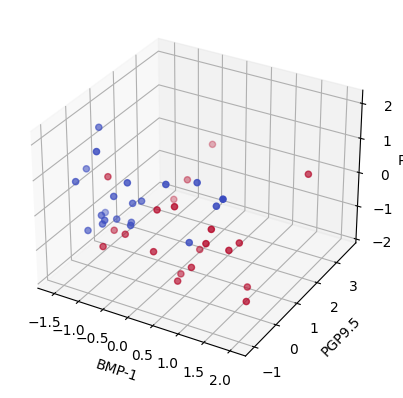

In [45]:
LogR_result, LogR_model = run_NESTED_CV("LR", None) #lowest score

In [66]:
lasso_result, lasso_model = run_NESTED_CV("lasso", None)

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 0.403, Best_Valid_Score: 0.397, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.01}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 0.418, Best_Valid_Score: 0.412, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.05}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.381, Best_Valid_Score: 0.426, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.01}

################################################################
 

################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.397, Best_Valid_Score: 0.391, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.02}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.420, Best_Valid_Score: 0.409, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.02}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 0.392, Best_Valid_Score: 0.424, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.02}

################################################################
 

################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.371, Best_Valid_Score: 0.453, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.01}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.377, Best_Valid_Score: 0.414, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.02}

################################################################
 

################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.385, Best_Valid_Score: 0.410, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.02}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.440, Best_Valid_Score: 0.369, 

Best_Model_Params: 
{'positive': False, 'alpha': 0.01}

################################################################
 
   itr_num  Valid Score  Test Score                              params  \
0        2     0.412310    0.417810  {'positive': False, 'alpha': 0.05}   
1        1     0.396856    0.402601  {'positive': False, 'alpha': 0.01}   
2        4     0.391231    0.396997  {'positive': False, 'alpha': 0.02}   
3        5     0.408803    0.419748  {'positive': False, 'alpha': 0.02}   
4        9     0.409984    0.384849  {'positive': False, 'alpha': 0.02}   
5        6     0.423671    0.391700  {'positive': False, 'alpha': 0.02}   
6        8     0.414228    0.376962  {'positive': False, 'alpha': 0.02}   
7        3     0.426378    0.381331  {'positive': False, 'alpha': 0.01}   
8       10     0.368622    0.439516  {'p

In [7]:
NN_result, NN_model = run_NESTED_CV("NN", None)

array([[0.        , 0.06408413, 0.        , ..., 0.05993837, 0.00586634,
        0.05961987],
       [0.        , 0.06408413, 0.        , ..., 0.05993837, 0.00586634,
        0.05961987],
       [0.        , 0.06408413, 0.        , ..., 0.05993837, 0.00586634,
        0.05961987],
       ...,
       [0.        , 0.06408413, 0.        , ..., 0.05993837, 0.02346525,
        0.05961987],
       [0.        , 0.06408413, 0.        , ..., 0.05993837, 0.02346525,
        0.05961987],
       [0.        , 0.06408413, 0.        , ..., 0.05993837, 0.02346525,
        0.05961987]])

array([[ 0.02590235,  0.04229815, -0.07195044, ...,  0.        ,
         0.04048882,  0.        ],
       [ 0.02037394,  0.0491716 , -0.04952433, ...,  0.        ,
         0.04048882,  0.        ],
       [ 0.02025796,  0.04679233, -0.0521577 , ...,  0.        ,
         0.04048882,  0.        ],
       ...,
       [ 0.0358187 ,  0.02802252, -0.01868843, ...,  0.        ,
         0.04048882,  0.14002801],
       [ 0.03599267,  0.02564325, -0.01987769, ...,  0.        ,
         0.04048882,  0.14002801],
       [ 0.03535478,  0.03013743, -0.01945295, ...,  0.        ,
         0.04048882,  0.14002801]])

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than


################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 0.019, Best_Valid_Score: 0.019, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 0.019, Best_Valid_Score: 0.018, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than


################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.017, Best_Valid_Score: 0.020, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.017, Best_Valid_Score: 0.017, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.018, Best_Valid_Score: 0.019, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 0.019, Best_Valid_Score: 0.019, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.0001, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.017, Best_Valid_Score: 0.021, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.001, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.018, Best_Valid_Score: 0.018, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.017, Best_Valid_Score: 0.019, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.01, 'activation': 'logistic'}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go


################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.019, Best_Valid_Score: 0.017, 

Best_Model_Params: 
{'learning_rate_init': 0.01, 'hidden_layer_sizes': (), 'batch_size': 16, 'alpha': 0.001, 'activation': 'logistic'}

################################################################
 
   itr_num  Valid Score  Test Score  \
0        4     0.017314    0.017354   
1        1     0.018760    0.018603   
2        2     0.018298    0.018573   
3        8     0.018489    0.017943   
4        6     0.019290    0.018539   
5        5     0.018779    0.017616   
6       10     0.017270    0.018794   
7        9     0.018813    0.016907   
8        3     0.019601    0.017347   
9        7     0.020870    0.017318   

                                              params  \
0  {'learning_rate_init': 0.01, 'hidden_layer_siz...   
1  {'learning_rate_init': 0.01, 'hidden_layer_siz...   
2  {'learning_rate_init': 0.01, 'hidd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.108098e-09,2.978270e-08,-5.074389e-08,-3.479531e-08,3.296239e-08,-1.656433e-09,-1.190559e-08,8.537187e-09,1.249705e-08,-6.284936e-09,-3.172532e-08,4.841933e-10,-6.324093e-08,-3.304761e-08
1,1.594142e-02,-3.304928e-02,-1.965911e-02,1.124442e-02,-1.363221e-01,4.224442e-02,5.008538e-02,-8.856109e-02,2.701528e-02,3.301136e-03,9.840390e-02,2.678028e-02,-1.240029e-02,1.581704e-01
2,-1.259237e-03,6.338317e-03,-7.008067e-02,1.361300e-02,-1.337895e-02,-2.738541e-02,2.542817e-02,4.761293e-02,-1.603313e-02,7.273429e-03,3.472574e-03,-1.232509e-02,1.034801e-02,-1.477799e-01
3,1.143736e-02,-1.327473e-01,-9.420271e-02,2.557011e-02,-2.022898e-01,-1.198012e-01,7.123905e-02,-8.863089e-02,-1.721548e-01,3.534326e-02,-1.271462e-01,-3.248392e-02,-9.022302e-02,2.435204e-01
4,4.840734e-01,2.918533e-01,3.582376e-01,9.234232e-02,2.660374e-01,2.231567e-01,2.813449e-01,6.610449e-02,1.269475e-01,-1.479721e-01,5.616237e-01,1.552364e-01,1.195431e-01,4.742451e-03
5,-4.065044e-02,9.715261e-02,2.078736e-01,1.447492e-01,1.906246e-01,-2.711494e-02,2.397303e-02,2.653718e-01,6.562883e-02,6.143110e-03,-1.513620e-02,-1.197880e-02,8.305976e-02,-3.254650e-02
6,-1.667229e-01,-1.245819e-01,-3.619188e-01,6.560763e-02,-1.306338e-01,-1.013413e-01,-3.271622e-04,-8.638791e-02,-1.283847e-01,4.291884e-02,-1.248419e-01,-5.731535e-02,-6.541336e-02,6.304666e-02
7,-1.622681e-02,9.448989e-03,-1.189342e-01,4.225214e-02,-9.660819e-02,-6.350377e-02,6.139701e-02,-8.177730e-02,-6.696906e-02,1.936362e-02,-6.260244e-02,-3.412562e-02,-4.600765e-02,-3.376423e-02
8,-3.866945e-02,-7.761306e-02,1.737995e-01,1.588425e-02,-6.167651e-02,-1.073291e-01,1.154197e-02,3.003523e-02,-1.463914e-01,2.942661e-02,-9.971005e-02,-2.965772e-02,-3.537545e-02,-8.241646e-02
9,-9.712404e-03,-3.036290e-02,1.832382e-01,4.026669e-02,5.530836e-02,6.149771e-02,1.364462e-01,3.126603e-02,6.562325e-02,4.335380e-03,1.938763e-02,-2.231091e-02,2.624062e-02,-2.360685e-02


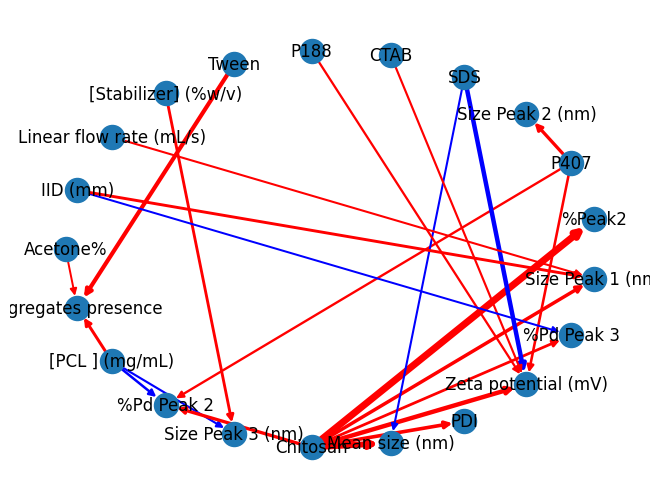

In [23]:
#print(NN_model.coefs_)
df=pd.DataFrame(NN_model.coefs_[0])
display(df)
df.to_excel(excel_writer="/kaggle/working/coefs.xlsx")
visualizeNN(NN_model.coefs_,xArr.columns,yArr.columns,0.14)

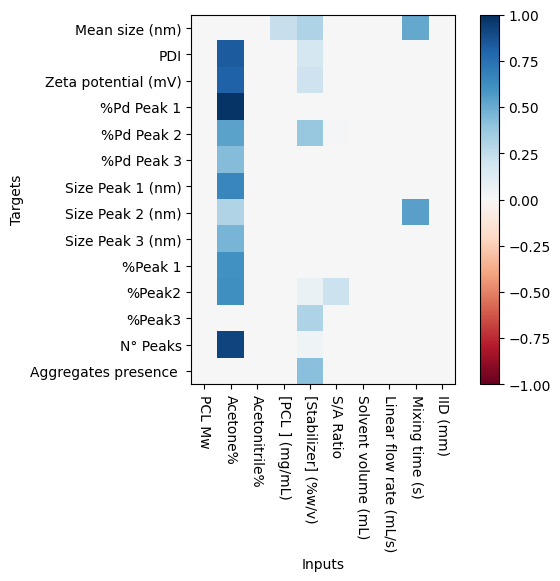

In [50]:
import matplotlib.pyplot as plt
import numpy as np

#coefs=NN_model.coefs_[0]
coefs=MLR_model.coef_
#coefs= pd.read_excel("/kaggle/input/nn-coefs/coefs.xlsx")
#print(len(coefs[0]))
#coefs=pd.DataFrame(coefs).iloc[:,1:]
#coefs=coefs.transpose()

fig, heatmap = plt.subplots()
plt.imshow(coefs, cmap='RdBu', interpolation='nearest', vmin = -1, vmax = 1)

plt.colorbar()

heatmap.set_xticks(np.arange(len(xArr.columns.values)), labels = xArr.columns.values, rotation=270)
heatmap.set_yticks(np.arange(len(yArr.columns.values)), labels = yArr.columns.values, rotation=0)

plt.xlabel("Inputs")
plt.ylabel("Targets")

plt.show()

In [73]:
kNN_result, kNN_model = run_NESTED_CV("kNN", None)

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])


################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 0.284, Best_Valid_Score: 0.259, 

Best_Model_Params: 
{'weights': 'distance', 'p': 1, 'n_neighbors': 6, 'metric': 'minkowski', 'leaf_size': 10, 'algorithm': 'kd_tree'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 0.268, Best_Valid_Score: 0.308, 

Best_Model_Params: 
{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 30, 'algorithm': 'kd_tree'}

################################################################
 

################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.265, Best_Valid_Score: 0.279, 

Best_Model_Params: 
{'weights': 'distance', 'p': 1, 'n_neighbors': 6, 'metric': 'minkowski', 'leaf_size': 100, 'a

In [53]:
PLS_result, PLS_model = run_NESTED_CV("PLS", None) # gives highest score

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 1.134, Best_Valid_Score: 0.566, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 1.134, Best_Valid_Score: 0.566, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.675, Best_Valid_Score: 0.918, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.890, Best_Val

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.690, Best_Valid_Score: 1.308, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 1.087, Best_Valid_Score: 0.515, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.890, Best_Valid_Score: 1.158, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.689, Best_Val

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.943, Best_Valid_Score: 0.587, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 

################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.707, Best_Valid_Score: 0.578, 

Best_Model_Params: 
{'n_components': 2, 'max_iter': 250}

################################################################
 
   itr_num  Valid Score  Test Score                                params  \
0        8     0.709888    0.688565  {'n_components': 2, 'max_iter': 250}   
1       10     0.578410    0.707065  {'n_components': 2, 'max_iter': 250}   
2        3     0.917789    0.675111  {'n_components': 2, 'max_iter': 250}   
3        4     1.157912    0.889905  {'n_components': 2, 'max_iter': 250}   
4        7     1.157912    0.889905  {'n_c

In [54]:
SVR_result, SVR_model = run_NESTED_CV("SVR", None)

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])

ValueError: 
All the 200 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (107, 14) instead.

--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (150, 14) instead.


In [55]:
DT_result, DT_model = run_NESTED_CV("DT", None) #gives lowest score

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])

/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 1.158, Best_Valid_Score: 0.374, 

Best_Model_Params: 
{'splitter': 'best', 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.1}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 1.158, Best_Valid_Score: 0.374, 

Best_Model_Params: 
{'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.15}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.525, Best_Valid_Score: 0.593, 

Best_Model_Params: 
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.05}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.486, Best_Valid_Score: 0.727, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'squared_error', 'ccp_alpha': 0.1}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.551, Best_Valid_Score: 0.609, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 1.169, Best_Valid_Score: 0.342, 

Best_Model_Params: 
{'splitter': 'best', 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.15}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.486, Best_Valid_Score: 0.727, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'squared_error', 'ccp_alpha': 0.1}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.687, Best_Valid_Score: 0.547, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.936, Best_Valid_Score: 0.405, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.05}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/conda/lib/python3.10/si


################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.449, Best_Valid_Score: 0.455, 

Best_Model_Params: 
{'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.1}

################################################################
 
   itr_num  Valid Score  Test Score  \
0       10     0.455145    0.449164   
1        5     0.608670    0.550617   
2        3     0.592951    0.524598   
3        8     0.547488    0.686958   
4        4     0.726686    0.485806   
5        7     0.726686    0.485806   
6        9     0.404537    0.935901   
7        1     0.374168    1.157880   
8        2     0.374168    1.157880   
9        6     0.341582    1.168820   

                                              params  \
0  {'splitter': 'random', 'min_samples_split': 4,...   
1  {'splitter': 'random', 'min_samples_split':

In [56]:
RF_result, RF_model = run_NESTED_CV("RF", None)

array([[ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.37038778,  0.27046016],
       ...,
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016],
       [ 0.        ,  0.48473722, -0.44017376, ...,  0.2798814 ,
        -0.03243135,  0.27046016]])

array([[-0.34925494, -0.15154232, -0.82637168, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48274877,  0.05532159, -0.35874591, ..., -0.08138189,
        -0.54871315, -0.45348116],
       [-0.48554934, -0.01628514, -0.41365651, ..., -0.08138189,
        -0.54871315, -0.45348116],
       ...,
       [-0.10980622, -0.58118275,  0.28423953, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.10560537, -0.65278949,  0.25944119, ..., -0.08138189,
        -0.54871315,  2.20516328],
       [-0.1210085 , -0.51753232,  0.26829774, ..., -0.08138189,
        -0.54871315,  2.20516328]])

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/util


################################################################

STATUS REPORT:
Iteration 1 of 10 runs completed
Test_Score: 1.125, Best_Valid_Score: 0.431, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.01, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
112 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 2 of 10 runs completed
Test_Score: 1.131, Best_Valid_Score: 0.437, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 400, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 6, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.01, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 3 of 10 runs completed
Test_Score: 0.527, Best_Valid_Score: 0.771, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 6, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.005, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
102 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 4 of 10 runs completed
Test_Score: 0.516, Best_Valid_Score: 0.838, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
116 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 5 of 10 runs completed
Test_Score: 0.546, Best_Valid_Score: 0.837, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
94 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
46 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/util


################################################################

STATUS REPORT:
Iteration 6 of 10 runs completed
Test_Score: 1.138, Best_Valid_Score: 0.382, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.01, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
94 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/util


################################################################

STATUS REPORT:
Iteration 7 of 10 runs completed
Test_Score: 0.516, Best_Valid_Score: 0.838, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
102 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 8 of 10 runs completed
Test_Score: 0.575, Best_Valid_Score: 0.594, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.005, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
96 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/util


################################################################

STATUS REPORT:
Iteration 9 of 10 runs completed
Test_Score: 0.912, Best_Valid_Score: 0.491, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0.005, 'bootstrap': True}

################################################################
 


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
104 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/uti


################################################################

STATUS REPORT:
Iteration 10 of 10 runs completed
Test_Score: 0.564, Best_Valid_Score: 0.490, 

Best_Model_Params: 
{'oob_score': True, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'ccp_alpha': 0, 'bootstrap': True}

################################################################
 
   itr_num  Valid Score  Test Score  \
0        8     0.594331    0.575196   
1       10     0.490024    0.564411   
2        3     0.770755    0.527382   
3        5     0.836811    0.545885   
4        4     0.838373    0.515769   
5        7     0.838373    0.515769   
6        9     0.491264    0.911773   
7        1     0.431244    1.124548   
8        2     0.436977    1.131310   
9        6     0.382013    1.137736   

                                    

In [59]:
print(RF_model.n_features_in_)

17


In [ ]:
#XGB_result, XGB_model = run_NESTED_CV("XGB", None)

In [ ]:
#LGBM_result, LGBM_model = run_NESTED_CV("LGBM", None)

In [ ]:
#NGB_result, NGB_model = run_NESTED_CV("NGB", None)

,MLR,kNN,RF,LR,lasso,DT,SVR
0,0.360626,0.01,0.403333,0.01,0.290590,0.01,0.674669
1,0.556968,0.99,0.446667,0.01,0.517534,0.01,0.782643
2,0.486678,0.99,0.486667,0.99,0.670388,0.99,0.648541
3,0.561105,0.99,0.466667,0.01,0.922860,0.01,0.327985
4,0.486555,0.01,0.460000,0.01,0.204165,0.99,0.263746
...,...,...,...,...,...,...,...
165,0.335665,0.99,0.670000,0.01,0.798275,0.99,0.975717
166,0.140131,0.01,0.376667,0.01,0.431877,0.01,0.055441
167,0.481372,0.99,0.716667,0.99,0.469622,0.99,0.968679
168,0.432129,0.99,0.623333,0.99,1.019083,0.99,0.972438


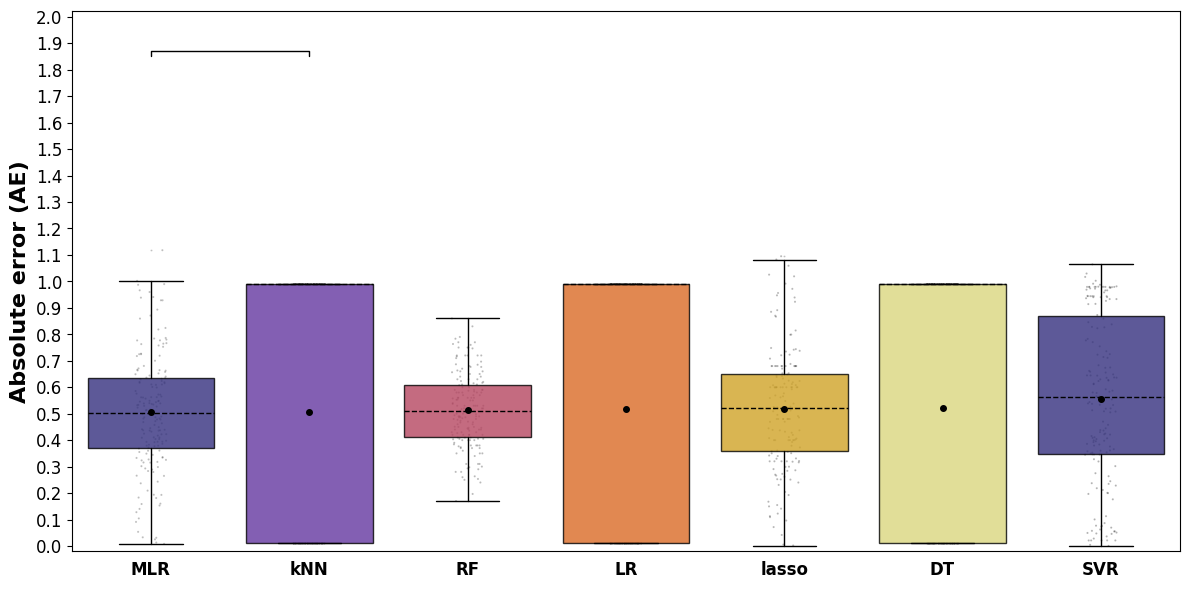

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
# results of all models in NESTED_CV

def extraction_all(name):
    '''
    function that extracts and compiles a results dataframe as well as an 
    absolute error array for all modesl in NESTED_CV_results pickle files
    '''
    if name == 'MLR':
        df = pd.read_pickle("/kaggle/working/MLR.pkl", compression='infer', storage_options=None)
        
    elif name == 'lasso':
        df =pd.read_pickle("/kaggle/working/lasso.pkl", compression='infer', storage_options=None)

    elif name == 'kNN':
        df =pd.read_pickle("/kaggle/working/kNN.pkl", compression='infer', storage_options=None)

    #elif name == 'PLS':
        #df =pd.read_pickle("/kaggle/working/PLS_model.pkl", compression='infer', storage_options=None)

    elif name == 'SVR':
        df = pd.read_pickle("/kaggle/working/SVR.pkl", compression='infer', storage_options=None)
        
    elif name == 'DT':
        df = pd.read_pickle("/kaggle/working/DT.pkl", compression='infer', storage_options=None)

    elif name == 'RF':
        df = pd.read_pickle("/kaggle/working/RF.pkl", compression='infer', storage_options=None)

    elif name == 'LR':
        df = pd.read_pickle("/kaggle/working/LR.pkl", compression='infer', storage_options=None)

    else:
        print("#######################\nSELECTION UNAVAILABLE!\n#######################\n\nPlease chose one of the following options:\n\n 'MLR' for multiple linear regression\n\n 'lasso' for multiple linear regression with east absolute shrinkage and selection operator (lasso)\n\n 'kNN'for k-Nearest Neighbors\n\n 'PLS' for partial least squares\n\n 'SVR' for support vertor regressor\n\n 'DT' for decision tree\n\n 'RF' for random forest\n\n 'LGBM' for LightGBM\n\n 'XBG' for XGBoost\n\n 'NGB' for NGBoost\n\n 'NN' for neural network")
    
    #df = pd.read_pickle(str(name)+"_NESTED_CV_results.pkl", compression='infer', storage_options=None)
    
    list_of_dataframes = []
    
    for n in range (10):
        dataframe = pd.DataFrame(df['y_test_list'][n], columns=['y_test_list'])
        dataframe['y_test_list'] = df['y_test_list'][n]
        dataframe['pred_list'] = df['pred_list'][n]
        #dataframe['Experimental Index'] = df['Experimental Index'][n]
        dataframe['Absolute_Error'] = abs(dataframe['y_test_list'] - dataframe['pred_list'])
        pd_series = dataframe['Absolute_Error']
        list_of_dataframes.append(dataframe)
    
    dataframe_all = pd.concat(list_of_dataframes, axis=0, ignore_index=True)
    #display(dataframe_all)
    return dataframe_all
    

ALL_MLR = extraction_all('MLR')
ALL_lasso = extraction_all('lasso')
ALL_kNN = extraction_all('kNN')
#ALL_PLS = extraction_all('PLS')
ALL_SVR = extraction_all('SVR')
ALL_DT = extraction_all('DT')
ALL_RF = extraction_all('RF')
ALL_NN = extraction_all('LR')

ALL_AE = pd.DataFrame(ALL_MLR['Absolute_Error'], columns=['MLR'])
ALL_AE['MLR'] = ALL_MLR['Absolute_Error']
ALL_AE['lasso'] = ALL_lasso['Absolute_Error']
ALL_AE['kNN'] = ALL_kNN['Absolute_Error']
#ALL_AE['PLS'] = ALL_PLS['Absolute_Error']
ALL_AE['SVR'] = ALL_SVR['Absolute_Error']
ALL_AE['DT'] = ALL_DT['Absolute_Error']
ALL_AE['RF'] = ALL_RF['Absolute_Error']
ALL_AE['LR'] = ALL_NN['Absolute_Error']
sorted_index = ALL_AE.mean().sort_values().index
df9=ALL_AE[sorted_index]
df9.to_excel("Figure_1_dataset.xlsx")
df9.describe()

# figure set-up - size
f, boxplot = plt.subplots(figsize=(12, 6))

# choose color scheme
#palette = sns.color_palette("Paired")
#palette = sns.color_palette("pastel")
#palette = sns.color_palette("tab10")
palette = sns.color_palette("CMRmap")

# set boxplot style
boxplot = sns.set_style("white")
df9.replace(0,0.01,inplace=True)
df9.replace(1,0.99,inplace=True)
display(df9)

# boxplot set up and box-whis style
boxplot = sns.boxplot(palette=palette, 
                      data=df9, saturation = 0.8,
                      boxprops = dict(linewidth=1.0, edgecolor='black', alpha = 0.8),
                      whiskerprops = dict(linewidth=1.0, color='black'),
                      capprops = dict(linewidth=1.0, color='black'),
                      flierprops=dict(marker="d", markerfacecolor= "black", markeredgecolor="black", 
                                      markersize =0.5, alpha=0.2),
                      medianprops=dict(color="black", linewidth=1.0, linestyle= '--'), 
                      showmeans=True,
                      meanprops=dict(marker="o", markerfacecolor="black", alpha=1.0,
                                     markeredgecolor="black", markersize=4, linewidth=0.05, zorder=10))

# include each datapoint
boxplot = sns.stripplot(data=df9, marker="o", edgecolor='white', 
                        alpha=0.3, size=1.5, linewidth=0.3, color='black', jitter = True, zorder=0)

# Title
#boxplot.axes.set_title("ML model performance ranked by mean absolute error", fontsize=18, color="white", weight="bold")

# Title - x-axis/y-axis
#boxplot.set_xlabel("Model index", fontsize=12)
boxplot.set_ylabel("Absolute error (AE)", fontsize=16, color='black', 
                   weight="bold")

# y-axis limits and interval
boxplot.set(ylim=(-0.02, 2.02), yticks=np.arange(0,2.02,0.1))
#sns.despine(left=False, bottom=False)

# x-axis rotation and text color
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 0, color='black', fontsize=12)

# x-axis and y-axis tick color
boxplot.tick_params(colors='black', which='both')  # 'both' refers to minor and major axes

# x-axis and y-axis label color
boxplot.axes.yaxis.label.set_color('black')
boxplot.axes.xaxis.label.set_color('black')

# format graph outline (color)
boxplot.spines['left'].set_color('black')
boxplot.spines['bottom'].set_color('black')
boxplot.spines['right'].set_color('black')
boxplot.spines['top'].set_color('black')

# add tick marks on x-axis or y-axis
boxplot.tick_params(bottom=False, left=True)

#statistical annotation
#text you want to show in italics
x1, x2 = 0, 1  
y, h, col = 1.85, 0.02, 'black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, '$\it{p < 0.05}$', ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
#text you want to show in italics
#x1, x2 = 0, 2  
#y, h, col = 0.925, 0.02, 'black'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.75, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, '$\it{p < 0.05}$', ha='center', va='bottom', color=col)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12, weight = "bold")

plt.tight_layout()

plt.savefig('BoxPLot', dpi=600, format = 'png', transparent=True, bbox_inches='tight')

plt.show()